# Groundwater Prediction with simple 3D-CNN

absichtlich "naives" CNN als Ausgangspunkt und Testmöglichkeit.
- max. Auflösung (ca. 1$km^2$ ro Zelle)
- keine Vorauswahl von Stationen / Herausfiltern von fehlenden Werten
- kein Padding
- Trainingszeitraum: 5 Jahre (2010-2014), Testzeitraum: 1 Jahr (2015)
- Eingabe: Messstände und Niederschlag der letzten ~30 Tage (4 Grundwasserdaten von aufeinander folgenden Daten, 28 Tage Niederschlag ab 1 Woche vor ersten Grundwasserdaten)
- Ausgabe: vorhergesagte Messstände für Woche nach Eingabezeitraum
- Zufällige Auswahl von Trainingseingaben aus Trainingszeitraum

In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/

In [2]:
import os
#don't use GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal_array
import glob
import random
import pandas as pd

In [4]:
data_drive = r'F:/'

In [5]:
regnie_path = data_drive + r'GruV-Net/data/precipitation/GTiff/'
ground_path = data_drive + r'GruV-Net/data/groundwater_levels_preprocessed_hesse/weekly/'

In [6]:
ground_files_train = glob.glob(ground_path+r'GTiff/'+'2010-*.tif') + glob.glob(ground_path+r'GTiff/'+'2011-*.tif') + glob.glob(ground_path+r'GTiff/'+'2012-*.tif') + glob.glob(ground_path+r'GTiff/'+'2013-*.tif') + glob.glob(ground_path+r'GTiff/'+'2014-*.tif')
ground_files_train = list(map(os.path.basename, ground_files_train))
ground_files_train.sort()

In [7]:
regnie_files_train = glob.glob(regnie_path+'ra10*.tif') + glob.glob(regnie_path+'ra11*.tif') + glob.glob(regnie_path+'ra12*.tif') + glob.glob(regnie_path+'ra13*.tif') + glob.glob(regnie_path+'ra14*.tif')
regnie_files_train = list(map(os.path.basename, regnie_files_train))
regnie_files_train.sort()

In [8]:
ground_files_test = glob.glob(ground_path+r'GTiff/'+'2015-*.tif')
ground_files_test = list(map(os.path.basename, ground_files_test))
ground_files_test.sort()

In [9]:
regnie_files_test = glob.glob(regnie_path+'ra15*.tif')
regnie_files_test = list(map(os.path.basename, regnie_files_test))
regnie_files_test.sort()

In [10]:
def generate_instances(n, ground_files, regnie_files, normalize=True):
    x = np.ndarray(shape=(n, 252, 142, 32, 1))
    y = np.ndarray(shape=(n, 1268))
    for i in range(n):
        r = random.randrange(0, len(ground_files)-4)
        ground_stack = np.ndarray(shape=(4, 252, 142))
        for j in range(r, r+4):
            ground_data = gdal_array.LoadFile(ground_path+r'GTiff/'+ground_files[j])
            #print(ground_files[j])
            ground_stack[j-r] = ground_data

        regnie_index = regnie_files.index('ra'+ground_files[r][2:4]+ground_files[r][5:7]+ground_files[r][8:10]+'.tif')
        regnie_stack = np.ndarray(shape=(28, 252, 142))
        for j in range(regnie_index-7, regnie_index+21):
            regnie_data = gdal_array.LoadFile(regnie_path+regnie_files[j])
            #print(regnie_files[j])
            regnie_stack[j-(regnie_index-7)] = regnie_data

        if normalize:
            ground_stack = tf.keras.utils.normalize(ground_stack)
            regnie_stack = tf.keras.utils.normalize(regnie_stack)
        x[i] = np.concatenate((ground_stack, regnie_stack)).reshape(252, 142, 32, 1)
        y[i] = pd.read_csv(ground_path+r'csv/'+ground_files[r+4][:-4]+'.csv').fillna(0)['VAL'].to_numpy()
    return x, y

In [11]:
n_train = 500
n_test = 100
x_train, y_train = generate_instances(n_train, ground_files_train, regnie_files_train)
x_test, y_test = generate_instances(n_test, ground_files_test, regnie_files_test)

In [12]:
x_train.shape

(500, 252, 142, 32, 1)

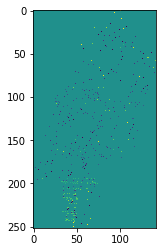

In [13]:
plt.imshow(x_train.reshape(n_train, 32, 252, 142)[0][3])

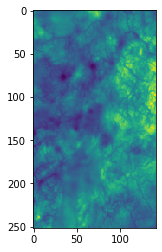

In [14]:
plt.imshow(x_train.reshape(n_train, 32, 252, 142)[0][20])

In [14]:
def create_Simple_3DCNN():
    return tf.keras.models.Sequential([
    tf.keras.layers.Conv3D(32, kernel_size=5, strides=(5, 5, 5), activation='relu', input_shape=(252, 142, 32, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1268)
])
GruV_Net_Simple_3DCNN = create_Simple_3DCNN()
GruV_Net_Simple_3DCNN.summary()
GruV_Net_Simple_3DCNN.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 50, 28, 6, 32)     4032      
_________________________________________________________________
flatten (Flatten)            (None, 268800)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               137626112 
_________________________________________________________________
dense_1 (Dense)              (None, 1268)              650484    
Total params: 138,280,628
Trainable params: 138,280,628
Non-trainable params: 0
_________________________________________________________________


In [15]:
hist = GruV_Net_Simple_3DCNN.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Train on 1000 samples, validate on 500 samples
Epoch 1/10
1000/1000 [==============================] - 57s 57ms/sample - loss: 8918.8570 - mean_absolute_error: 56.3378 - val_loss: 3676.4315 - val_mean_absolute_error: 33.5703
Epoch 2/10
1000/1000 [==============================] - 51s 51ms/sample - loss: 2205.2452 - mean_absolute_error: 23.3647 - val_loss: 2757.3284 - val_mean_absolute_error: 20.7189
Epoch 3/10
1000/1000 [==============================] - 51s 51ms/sample - loss: 1588.4931 - mean_absolute_error: 13.8809 - val_loss: 2617.6715 - val_mean_absolute_error: 16.1545
Epoch 4/10
1000/1000 [==============================] - 51s 51ms/sample - loss: 1548.6361 - mean_absolute_error: 12.0646 - val_loss: 2622.8051 - val_mean_absolute_error: 16.2163
Epoch 5/10
1000/1000 [==============================] - 55s 55ms/sample - loss: 1537.7996 - mean_absolute_error: 12.0314 - val_loss: 2716.8541 - val_mean_absolute_error: 17.8674
Epoch 6/10
1000/1000 [==============================] - 52s 52m

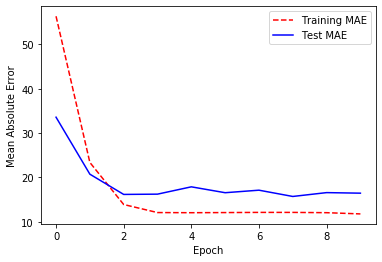

In [16]:
training_mae = hist.history['mean_absolute_error']
test_mae = hist.history['val_mean_absolute_error']

plt.plot(training_mae, 'r--')
plt.plot(test_mae, 'b-')
plt.legend(['Training MAE', 'Test MAE'])
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.show()

In [15]:
def create_Harti_3DCNN():
    return tf.keras.models.Sequential([
    tf.keras.layers.Conv3D(32, kernel_size=(5,3,3), activation='relu', input_shape=(252, 142, 32, 1)),
    tf.keras.layers.MaxPooling3D(pool_size=(5,3,3)),
    tf.keras.layers.Conv3D(64, kernel_size=(5,3,3), activation='relu'),
    tf.keras.layers.MaxPooling3D(pool_size=(2,2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dropout(rate = 0.1),
    tf.keras.layers.Dense(1268)
])
GruV_Net_Harti_3DCNN = create_Harti_3DCNN()
GruV_Net_Harti_3DCNN.summary()
GruV_Net_Harti_3DCNN.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 248, 140, 30, 32)  1472      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 49, 46, 10, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 45, 44, 8, 64)     92224     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 22, 22, 4, 64)     0         
_________________________________________________________________
flatten (Flatten)            (None, 123904)            0         
_________________________________________________________________
dense (Dense)                (None, 2048)              253757440 
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0

In [16]:
hist_harti = GruV_Net_Harti_3DCNN.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=10)

Train on 500 samples, validate on 100 samples
Epoch 1/10
500/500 [==============================] - 2498s 5s/sample - loss: 4333.4598 - mean_absolute_error: 35.7310 - val_loss: 2823.5964 - val_mean_absolute_error: 20.0081
Epoch 2/10
500/500 [==============================] - 2491s 5s/sample - loss: 1690.2948 - mean_absolute_error: 18.4455 - val_loss: 2800.5663 - val_mean_absolute_error: 19.7512
Epoch 3/10
500/500 [==============================] - 2490s 5s/sample - loss: 1677.8376 - mean_absolute_error: 17.7920 - val_loss: 2746.6281 - val_mean_absolute_error: 19.7899
Epoch 4/10
500/500 [==============================] - 2447s 5s/sample - loss: 1637.0745 - mean_absolute_error: 16.8236 - val_loss: 2629.5467 - val_mean_absolute_error: 21.8962
Epoch 5/10
500/500 [==============================] - 2441s 5s/sample - loss: 1641.9653 - mean_absolute_error: 16.9696 - val_loss: 2901.8460 - val_mean_absolute_error: 18.4194
Epoch 6/10
500/500 [==============================] - 2439s 5s/sample - lo

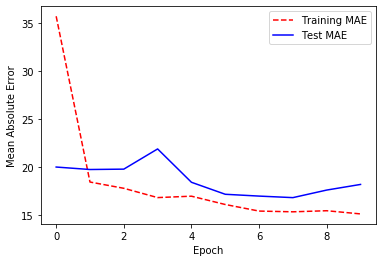

In [17]:
training_mae = hist_harti.history['mean_absolute_error']
test_mae = hist_harti.history['val_mean_absolute_error']

plt.plot(training_mae, 'r--')
plt.plot(test_mae, 'b-')
plt.legend(['Training MAE', 'Test MAE'])
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.show()